### Imports

In [86]:
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [87]:
file_path = "../data/rents_returns_by_bike_Dresden_01-03_09-10.24.pkl" 
df = pd.read_pickle(file_path)

# define tools

In [88]:
from datetime import datetime
import pyreadr


def get_filename(time):
    return f'../data/Dresden_01-03.24/{time.strftime("%Y-%m-%d")}/{time.strftime("%Y-%m-%d-%H-%M-00")}.rds'



def import_raw_file(year,month, day, hour, minute, second):
    time = datetime(year,month, day, hour, minute, second)
    current_filename = get_filename(time)
    df = pyreadr.read_r(current_filename)[None]
    return df


# Explore anomalies

In [89]:
df.head()

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return,date,datetime,datetime_hour
74137,2024-01-01 00:03:00,930174,True,339094509,51.049316,13.745968,NaN,<NA>,rent,2024-01-01,2024-01-01 00:03:00,2024-01-01
200123,2024-01-01 00:04:00,930469,True,339072110,51.039084,13.732190,NaN,<NA>,rent,2024-01-01,2024-01-01 00:04:00,2024-01-01
433040,2024-01-01 00:05:00,931013,True,339051262,51.052498,13.737698,NaN,<NA>,rent,2024-01-01,2024-01-01 00:05:00,2024-01-01
783377,2024-01-01 00:06:00,931730,True,339099175,51.068849,13.763910,NaN,<NA>,rent,2024-01-01,2024-01-01 00:06:00,2024-01-01
522845,2024-01-01 00:07:00,931218,False,69479028,51.062868,13.751493,Bautzner Straße / Rothenburger Straße,43136,rent,2024-01-01,2024-01-01 00:07:00,2024-01-01


# datetime_counts

In [34]:
datetime_counts = df.groupby("datetime").rent_or_return.value_counts().unstack(fill_value=0)

In [8]:
datetime_counts.columns

Index(['rent', 'returns'], dtype='object', name='rent_or_return')

In [9]:
datetime_counts

rent_or_return,rent,returns
datetime,,
2024-01-01 00:03:00,1,0
2024-01-01 00:04:00,1,0
2024-01-01 00:05:00,1,0
2024-01-01 00:06:00,1,0
2024-01-01 00:07:00,1,0
...,...,...
2024-10-31 23:54:00,1,2
2024-10-31 23:55:00,3,2
2024-10-31 23:56:00,0,3


In [10]:
datetime_counts = datetime_counts.sort_values("rent", ascending=False)

In [11]:
datetime_counts.head(10)

rent_or_return,rent,returns
datetime,,
2024-02-14 00:40:00,182,0
2024-02-14 00:14:00,148,0
2024-09-20 15:06:00,147,4
2024-02-13 23:36:00,120,4
2024-02-14 01:07:00,101,0
2024-02-14 08:00:00,93,79
2024-02-14 08:08:00,84,5
2024-02-14 07:58:00,80,6
2024-02-13 23:37:00,69,0


In [12]:
datetime_counts = datetime_counts.sort_values("returns", ascending=False)

In [13]:
datetime_counts.head(10)
# too many bikes returned at 2024-02-14 00:27:00

rent_or_return,rent,returns
datetime,,
2024-09-20 15:07:00,7,192
2024-10-09 15:06:00,9,189
2024-02-14 00:27:00,1,173
2024-09-22 12:06:00,3,160
2024-09-20 13:55:00,0,137
2024-02-14 01:20:00,0,110
2024-10-27 03:01:00,3,99
2024-02-14 08:10:00,2,85
2024-02-14 08:02:00,69,80


In [14]:
datetime_counts.query("rent-returns>100")

rent_or_return,rent,returns
datetime,,
2024-09-20 15:06:00,147,4
2024-02-13 23:36:00,120,4
2024-02-14 00:14:00,148,0
2024-02-14 01:07:00,101,0
2024-02-14 00:40:00,182,0


In [15]:
tmp = datetime_counts.query("rent > 50 or returns > 50").sort_index()

In [16]:
tmp

rent_or_return,rent,returns
datetime,,
2024-02-12 22:54:00,0,65
2024-02-13 23:36:00,120,4
2024-02-13 23:37:00,69,0
2024-02-13 23:51:00,3,60
2024-02-13 23:52:00,3,71
...,...,...
2024-09-24 16:04:00,22,52
2024-09-24 16:05:00,30,60
2024-09-24 16:10:00,38,53


In [14]:
df.columns

Index(['time_stamp', 'bike_number', 'bike', 'uid', 'lat', 'lng', 'name',
       'station_number', 'rent_or_return', 'date', 'datetime',
       'datetime_hour'],
      dtype='object')

# explore strange time period 14th Feb 40 and 27 min

In [129]:
start = datetime(2024, 2, 14, 0, 0, 0)
end = datetime(2024, 2, 14, 1, 59, 0)

In [135]:
df_anomaly = df[(df.datetime>=start) & (df.datetime<=end)][["datetime", "bike_number", "station_number", "uid", "rent_or_return", "name", "lat", "lng"]]

In [136]:
df_anomaly = df_anomaly.sort_values(["bike_number", "datetime"])

In [113]:
start_bikes = set(df[df.datetime==start].bike_number)

In [114]:
end_bikes = set(df[df.datetime==end].bike_number)

In [115]:
len(start_bikes)

4

In [116]:
len(end_bikes)

0

In [117]:
len(start_bikes-end_bikes)

4

In [118]:
len(end_bikes-start_bikes)

0

In [119]:
# looks like bikes were replaces by new ones ... or renamed? or is everything normal?

In [27]:
df_start = import_raw_file(2024, 2, 14, 0, 27, 0)

In [28]:
df_end = import_raw_file(2024, 2, 14, 0, 40, 0)

In [29]:
len(set(df_end.bike_number))

1346

In [30]:
len(set(df_end.boardcomputer))

1346

In [31]:
len(set(df_start.boardcomputer))

1334

In [32]:
len(set(df_start.bike_number))

1334

In [33]:
len(set(df_start.boardcomputer)-set(df_end.boardcomputer))

8

In [34]:
len(set(df_end.boardcomputer)-set(df_start.boardcomputer))

20

In [35]:
len(set(df_start.bike_number)-set(df_end.bike_number))

8

In [36]:
len(set(df_end.bike_number)-set(df_start.bike_number))

20

columns_to_keep = ["time_stamp", "bike_number", "bike", "uid", "lat", "lng", "name", "station_number", "boardcomputer"]
start_time = start
end_time = end

rent_list=[]
return_list=[]

lag_time = start_time - timedelta(minutes=1)
lag_filename = get_filename(lag_time)
df_lag = pyreadr.read_r(lag_filename)[None][columns_to_keep]
lag_bike_numbers = set(df_lag.bike_number)

for current_time in [start, end]:
        current_filename = get_filename(current_time)
        try:
                df_current = pyreadr.read_r(current_filename)[None][columns_to_keep]
                current_bike_numbers = set(df_current.bike_number)

                rented_bikes = df_lag[df_lag.bike_number.isin(lag_bike_numbers-current_bike_numbers)]
                if not rented_bikes.empty:
                        rent_list.extend(rented_bikes.to_dict(orient="records"))

                returned_bikes = df_current[df_current.bike_number.isin(current_bike_numbers-lag_bike_numbers)]
                if not returned_bikes.empty:
                        return_list.extend(returned_bikes.to_dict(orient="records"))
                
                df_lag = df_current
                lag_bike_numbers = current_bike_numbers
        except Exception as e:
                pass

df = pd.DataFrame(rent_list)
df['rent_or_return']="rent"
df_return = pd.DataFrame(return_list)
df_return['rent_or_return']="returns"
df = pd.concat([df,df_return], ignore_index=True)
df = df.sort_values(["bike_number", "time_stamp"])

df.groupby(["time_stamp","rent_or_return"]).size()

In [137]:
df_anomaly_counts = df_anomaly.groupby(["datetime"]).rent_or_return.value_counts().unstack(fill_value=0)

In [138]:
df_anomaly

,datetime,bike_number,station_number,uid,rent_or_return,name,lat,lng
1414,2024-02-14 00:07:00,930004,43028,32941248,rent,MOBIpunkt S-Bf. Bischofsplatz,51.071875,13.746133
1415,2024-02-14 00:20:00,930004,43001,32938439,returns,MOBIpunkt Bahnhof Mitte,51.056030,13.722850
5528,2024-02-14 00:40:00,930013,<NA>,360131423,rent,NaN,51.028551,13.794028
5529,2024-02-14 00:56:00,930013,<NA>,360131423,returns,NaN,51.028551,13.794028
6124,2024-02-14 00:40:00,930016,<NA>,360143616,rent,NaN,51.070600,13.762762
...,...,...,...,...,...,...,...,...
813404,2024-02-14 00:16:00,931788,<NA>,360304648,returns,NaN,51.042960,13.737539
813781,2024-02-14 00:40:00,931789,<NA>,360334276,rent,NaN,51.049307,13.711332
813782,2024-02-14 01:01:00,931789,<NA>,360334276,returns,NaN,51.049307,13.711332
818587,2024-02-14 01:08:00,931798,<NA>,360307796,rent,NaN,51.075773,13.754183


In [139]:
df_anomaly.uid.dropna()

1414       32941248
1415       32938439
5528      360131423
5529      360131423
6124      360143616
            ...    
813404    360304648
813781    360334276
813782    360334276
818587    360307796
818588    360307796
Name: uid, Length: 1425, dtype: int64

In [140]:
df_anomaly_counts.query("rent>50 or returns>50")

rent_or_return,rent,returns
datetime,,
2024-02-14 00:14:00,148,0
2024-02-14 00:27:00,1,173
2024-02-14 00:40:00,182,0
2024-02-14 00:55:00,0,67
2024-02-14 00:56:00,0,53
2024-02-14 01:07:00,101,0
2024-02-14 01:08:00,58,0
2024-02-14 01:20:00,0,110


In [141]:
df_anomaly_counts_by_uid = df_anomaly.groupby(["datetime", "uid"]).rent_or_return.value_counts().unstack(fill_value=0)

In [145]:
df_anomaly_counts_by_uid.query("rent>1 or returns>1")

,rent_or_return,rent,returns
datetime,uid,,
2024-02-14 00:07:00,32941248,2,0
2024-02-14 00:16:00,32941375,0,3
2024-02-14 00:40:00,43315815,2,0
2024-02-14 00:50:00,32941248,2,0
2024-02-14 00:58:00,41460926,0,2
2024-02-14 01:20:00,75387835,0,2
2024-02-14 01:43:00,50758875,0,2


In [109]:
df_anomaly.datetime.unique()


<DatetimeArray>
['2024-02-14 00:27:00', '2024-02-14 00:28:00', '2024-02-14 00:30:00',
 '2024-02-14 00:32:00', '2024-02-14 00:33:00', '2024-02-14 00:34:00',
 '2024-02-14 00:35:00', '2024-02-14 00:36:00', '2024-02-14 00:37:00',
 '2024-02-14 00:38:00', '2024-02-14 00:39:00', '2024-02-14 00:40:00']
Length: 12, dtype: datetime64[ns]

In [106]:
len(df_anomaly_counts)

6

# plot of one day

In [36]:
datetime_counts

rent_or_return,rent,returns
datetime,,
2024-01-01 00:03:00,1,0
2024-01-01 00:04:00,1,0
2024-01-01 00:05:00,1,0
2024-01-01 00:06:00,1,0
2024-01-01 00:07:00,1,0
...,...,...
2024-10-31 23:54:00,1,2
2024-10-31 23:55:00,3,2
2024-10-31 23:56:00,0,3


array([datetime.date(2024, 1, 1), datetime.date(2024, 1, 1),
       datetime.date(2024, 1, 1), ..., datetime.date(2024, 10, 31),
       datetime.date(2024, 10, 31), datetime.date(2024, 10, 31)],
      dtype=object)

In [41]:
datetime_counts[datetime_counts.index.date==pd.to_datetime("2024-02-14").date()]

rent_or_return,rent,returns
datetime,,
2024-02-14 00:00:00,2,2
2024-02-14 00:01:00,2,1
2024-02-14 00:02:00,2,0
2024-02-14 00:03:00,1,5
2024-02-14 00:05:00,1,0
...,...,...
2024-02-14 23:55:00,4,0
2024-02-14 23:56:00,4,4
2024-02-14 23:57:00,1,2


In [148]:
def plot_day(day_str):
    plt.figure(figsize=(10, 5)) 
    filtered_data = datetime_counts[datetime_counts.index.date==pd.to_datetime(day_str).date()]
    sns.lineplot(data = filtered_data)
    plt.title(f"Rents and returns by minute on {day_str}")
    plt.xticks(rotation=90)
    plt.savefig(f"../data/images/{day_str}.png", bbox_inches='tight')
    plt.close()
    

In [150]:
plot_day("2024-02-11")

In [152]:
plot_day("2024-03-01")

In [151]:
plot_day("2024-10-24")

In [159]:
for pd_date in tqdm(pd.date_range(start="2024-09-03", end="2024-10-31")):
    str_date = pd_date.strftime("%Y-%m-%d")
    plot_day(str_date)
    
    

  0%|          | 0/59 [00:00<?, ?it/s]

# date_counts

In [43]:
date_counts = df.groupby("date").rent_or_return.value_counts().unstack(fill_value=0)

In [44]:
date_counts

rent_or_return,rent,returns
date,,
2024-01-01,2611,2586
2024-01-02,2059,2012
2024-01-03,4049,3961
2024-01-04,3680,3634
2024-01-05,4747,4740
...,...,...
2024-10-27,6148,6187
2024-10-28,7246,7236
2024-10-29,7285,7315


In [45]:
date_counts.sort_values("rent", ascending=False).head(10)

rent_or_return,rent,returns
date,,
2024-03-01,14046,13949
2024-03-22,13703,13608
2024-02-02,13014,12921
2024-03-02,10944,10901
2024-10-23,8030,7982
2024-10-22,7757,7783
2024-10-21,7637,7604
2024-10-30,7634,7571
2024-10-25,7487,7455


<Axes: xlabel='date'>

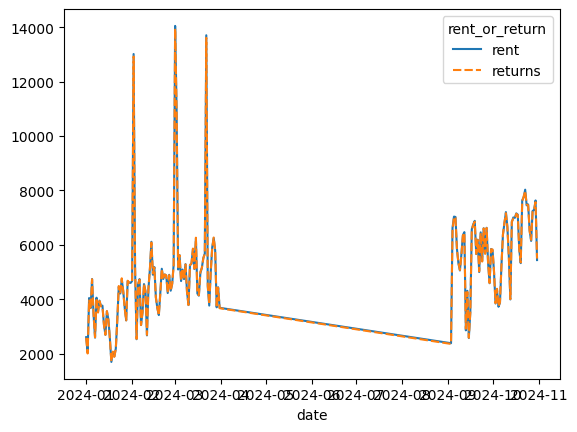

In [46]:
sns.lineplot(date_counts)

# hour_counts

In [47]:
hour_counts = df.groupby("datetime_hour").rent_or_return.value_counts().unstack(fill_value=0)

<Axes: xlabel='datetime_hour'>

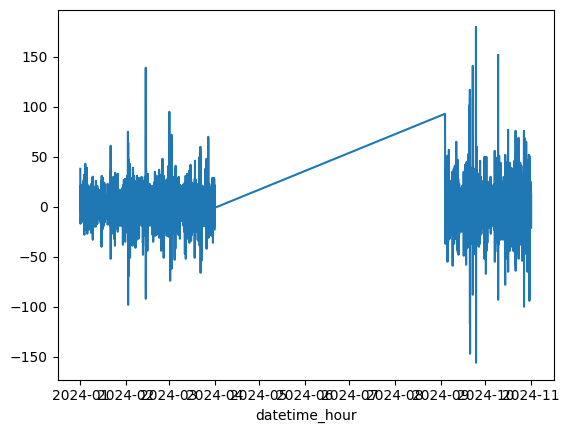

In [50]:
sns.lineplot(hour_counts.rent-hour_counts["returns"])

In [51]:
hourly_diffs = hour_counts.rent-hour_counts["returns"]

In [52]:
hourly_diffs.sort_values()

datetime_hour
2024-09-24 16:00:00   -156
2024-09-20 15:00:00   -147
2024-09-20 13:00:00   -117
2024-10-27 03:00:00   -100
2024-02-02 09:00:00    -98
                      ... 
2024-09-20 12:00:00    117
2024-02-14 07:00:00    139
2024-09-22 11:00:00    141
2024-10-09 14:00:00    152
2024-09-24 15:00:00    180
Length: 3583, dtype: int64

In [ ]:
hour_counts.query("rent-returns>100")
#suspiciously the top differences are at 00 minutes

rent_or_return,rent,returns
datetime_hour,,
2024-02-14 07:00:00,325,186
2024-09-20 10:00:00,224,122
2024-09-20 12:00:00,170,53
2024-09-20 14:00:00,179,70
2024-09-22 11:00:00,206,65
2024-09-24 15:00:00,246,66
2024-10-09 14:00:00,314,162


<Axes: xlabel='datetime_hour'>

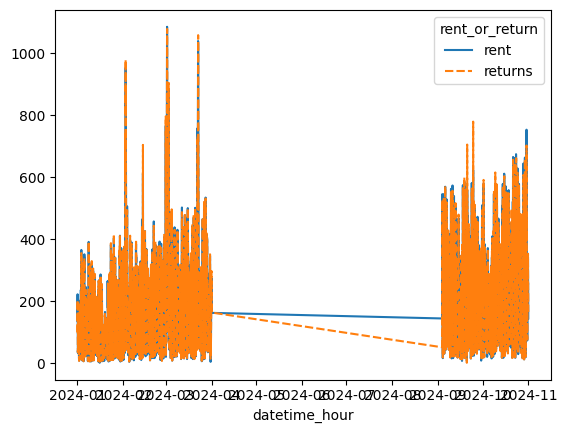

In [55]:
sns.lineplot(hour_counts)

# unique bikes
bikes get added and excluded throughout the timeline

In [56]:
jan_bikes = set(df[df.datetime.dt.month==1].bike_number.unique())
feb_bikes = set(df[df.datetime.dt.month==2].bike_number.unique())
mar_bikes = set(df[df.datetime.dt.month==3].bike_number.unique())

In [57]:
len(feb_bikes-jan_bikes)

214

In [58]:
len(jan_bikes)

1475

In [59]:
len(feb_bikes-jan_bikes)

214

In [60]:
len(jan_bikes-feb_bikes)

59

In [61]:
df.datetime.dt.month

74137       1
200123      1
433040      1
783377      1
522845      1
           ..
1278670    10
1484054    10
1128362    10
1265697    10
1331524    10
Name: datetime, Length: 1538911, dtype: int32

In [ ]:
len(df.bike_number.unique())

1860

In [ ]:
len(df)-len(df.drop_duplicates())

0

In [ ]:
df

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return,date
481181,2024-01-19 08:43:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003.0,return,2024-01-19
64361,2024-01-21 15:39:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003.0,rent,2024-01-21
486104,2024-01-21 15:46:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003.0,return,2024-01-21
64421,2024-01-21 15:50:00,930000,False,32939517,51.048930,13.744200,MOBIpunkt Pirnaischer Platz,43003.0,rent,2024-01-21
486217,2024-01-21 16:09:00,930000,True,348898836,51.033422,13.707902,NaN,NaN,return,2024-01-21
...,...,...,...,...,...,...,...,...,...,...
830000,2024-03-28 17:02:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432.0,return,2024-03-28
407930,2024-03-28 17:34:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432.0,rent,2024-03-28
830216,2024-03-28 17:39:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432.0,return,2024-03-28
408412,2024-03-28 18:42:00,932013,False,382962921,48.134627,11.610754,Mentz Büro,32432.0,rent,2024-03-28


# individual bike checks

In [ ]:
df[df.bike_number==931492]

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return
79,2024-01-31 01:56:00,931492,False,55466724,51.029253,13.730582,Hörsaalzentrum TU Dresden,43116.0,rent


In [ ]:
df[df.bike_number==931492]

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return
79,2024-01-31 01:56:00,931492,False,55466724,51.029253,13.730582,Hörsaalzentrum TU Dresden,43116.0,rent


In [ ]:
df[df.bike_number==930494]  

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return
78,2024-01-31 01:47:00,930494,True,353304968,51.070476,13.747492,NaN,NaN,rent
166,2024-01-31 01:57:00,930494,True,353375953,51.057511,13.724396,NaN,NaN,return


In [ ]:
df[df.bike_number==930494]

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return
78,2024-01-31 01:47:00,930494,True,353304968,51.070476,13.747492,NaN,NaN,rent
166,2024-01-31 01:57:00,930494,True,353375953,51.057511,13.724396,NaN,NaN,return


In [ ]:
df[df.bike_number==930009].sort_values("datetime")

,time_stamp,bike_number,bike,uid,lat,lng,name,station_number,rent_or_return,date,datetime,datetime_hour
171289,2024-02-14 09:31:00,930009,False,32939970,51.031190,13.727290,MOBIpunkt TU Dresden,43005,rent,2024-02-14,2024-02-14 09:31:00,2024-02-14 09:00:00
593305,2024-02-14 09:33:00,930009,False,32939970,51.031190,13.727290,MOBIpunkt TU Dresden,43005,returns,2024-02-14,2024-02-14 09:33:00,2024-02-14 09:00:00
171326,2024-02-14 09:39:00,930009,False,32939970,51.031190,13.727290,MOBIpunkt TU Dresden,43005,rent,2024-02-14,2024-02-14 09:39:00,2024-02-14 09:00:00
593344,2024-02-14 09:43:00,930009,False,77690732,51.029111,13.728472,StuRa-Baracke,43143,returns,2024-02-14,2024-02-14 09:43:00,2024-02-14 09:00:00
172631,2024-02-14 14:14:00,930009,False,77690732,51.029111,13.728472,StuRa-Baracke,43143,rent,2024-02-14,2024-02-14 14:14:00,2024-02-14 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
405503,2024-03-28 10:53:00,930009,True,382830853,51.047284,13.737177,NaN,<NA>,rent,2024-03-28,2024-03-28 10:53:00,2024-03-28 10:00:00
827794,2024-03-28 10:56:00,930009,True,382833096,51.047369,13.736960,NaN,<NA>,returns,2024-03-28,2024-03-28 10:56:00,2024-03-28 10:00:00
405927,2024-03-28 12:13:00,930009,True,382835233,51.047364,13.736957,NaN,<NA>,rent,2024-03-28,2024-03-28 12:13:00,2024-03-28 12:00:00
405963,2024-03-28 12:21:00,930009,True,382867235,51.042636,13.751184,NaN,<NA>,rent,2024-03-28,2024-03-28 12:21:00,2024-03-28 12:00:00
